In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import typing as tp

import arch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

from ovm.simulation.bootstrap import (
    convert_block_lenghts_to_seconds, 
    convert_and_ceil_time_period_from_seconds_to_number_of_periods, 
    estimate_optimal_block_lengths_for_multiple_price_series, 
    estimate_optimal_block_lengths_in_seconds_for_multiple_price_series, 
    plot_multivariate_simulation
)
    
from ovm.historical.data_io import (
    PriceHistoryColumnNames as PHCN, 
    compute_number_of_days_in_price_history, 
    compute_log_returns_from_price_history, 
    save_price_histories, 
    load_price_history, 
    load_price_histories, 
    construct_series_name_to_closing_price_map, 
    construct_closing_price_df, 
    compute_log_return_df
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.time_resolution import TimeResolution

environment variable OVERLAY_MONETARY_BASE_PATH not set defaulting to /home/michael/PycharmProjects/overlay-monetary


In [3]:
from recombinator import (
    stationary_bootstrap, 
    tapered_block_bootstrap
)

from recombinator.optimal_block_length import optimal_block_length

In [4]:
%matplotlib inline

In [5]:
time_resolution = TimeResolution.FIFTEEN_MINUTES
directory_path = \
    construct_historical_data_directory(
        historical_data_source=HistoricalDataSource.FTX, 
        time_resolution=time_resolution)

directory_path

'/home/michael/PycharmProjects/overlay-monetary/data/historical/ftx/15m'

In [6]:
series_names = \
    ['BTC-USD', 
     'ETH-USD', 
     'AAVE-USD', 
     'YFI-USD', 
     'UNI-USD', 
     'BAL-USD', 
     'COMP-USD', 
     'LINK-USD', 
     'CREAM-USD', 
     'SUSHI-USD' ]

In [7]:
series_name_to_price_history_map = \
    load_price_histories(series_names=series_names, 
                         period_length_in_seconds=time_resolution.in_seconds, 
                         directory_path=directory_path)

In [8]:
series_name_to_data_length_map = \
    {series_name: len(price_history.price_history_df)
     for series_name, price_history 
     in series_name_to_price_history_map.items()}
series_name_to_data_length_map

{'BTC-USD': 47353,
 'ETH-USD': 42052,
 'AAVE-USD': 4308,
 'YFI-USD': 11873,
 'UNI-USD': 6702,
 'BAL-USD': 14761,
 'COMP-USD': 15360,
 'LINK-USD': 21010,
 'CREAM-USD': 7330,
 'SUSHI-USD': 8261}

In [9]:
series_name_to_data_length_map['YFI-USD'] * time_resolution.in_seconds / 60 / 60 / 24

123.67708333333333

In [10]:
selected_series_names = \
    ['BTC-USD', 
     'ETH-USD', 
     'YFI-USD', 
     'BAL-USD', 
     'COMP-USD', 
     'LINK-USD']

In [11]:
series_name_to_optimal_block_length_map = \
    estimate_optimal_block_lengths_for_multiple_price_series(series_name_to_price_history_map, 
                                                             moment=1.0)

100%|██████████| 10/10 [00:00<00:00, 32.40it/s]


In [12]:
series_name_to_block_lengths_in_seconds_map = \
    convert_block_lenghts_to_seconds(series_name_to_optimal_block_length_map, 
                                     period_length_in_seconds=time_resolution.in_seconds)
series_name_to_block_lengths_in_seconds_map

{'BTC-USD': 53805.20232678347,
 'ETH-USD': 25813.264459000093,
 'AAVE-USD': 2390.5476862387286,
 'YFI-USD': 1742.7813342914683,
 'UNI-USD': 3372.5955728885147,
 'BAL-USD': 5821.908768821017,
 'COMP-USD': 26408.615697511777,
 'LINK-USD': 10629.986144578439,
 'CREAM-USD': 3024.653384908744,
 'SUSHI-USD': 1512.9629972802334}

In [13]:
340197 / 60 / 60 / 24

3.9374652777777777

In [14]:
max_optimal_block_length_in_seconds_for_selected_series = \
    max(block_lengths_in_seconds 
        for series_name, block_lengths_in_seconds 
        in series_name_to_block_lengths_in_seconds_map.items() 
        if series_name in selected_series_names)
max_optimal_block_length_in_seconds_for_selected_series

53805.20232678347

In [15]:
series_name_to_closing_price_map = \
    construct_series_name_to_closing_price_map(series_name_to_price_history_map)

In [16]:
df = pd.DataFrame(data=series_name_to_closing_price_map)

In [17]:
df.head()

,BTC-USD,ETH-USD,AAVE-USD,YFI-USD,UNI-USD,BAL-USD,COMP-USD,LINK-USD,CREAM-USD,SUSHI-USD
start_time,,,,,,,,,,
1563714000000,10542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563714900000,10584.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563715800000,10568.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563716700000,10535.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563717600000,10531.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.diff()

,BTC-USD,ETH-USD,AAVE-USD,YFI-USD,UNI-USD,BAL-USD,COMP-USD,LINK-USD,CREAM-USD,SUSHI-USD
start_time,,,,,,,,,,
1563714000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563714900000,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563715800000,-16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563716700000,-32.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563717600000,-4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1606341600000,0.0,-1.55,-0.45,-305.0,-0.033,-0.3975,-0.66,-0.1095,0.05,-0.0047
1606342500000,-58.0,-6.09,-0.82,-275.0,-0.037,-0.3275,-2.05,-0.1210,-0.40,-0.0231
1606343400000,-90.5,-5.31,-0.54,-105.0,-0.062,-0.0125,-0.45,-0.2555,-0.05,-0.0329


In [19]:
len(np.log(df).diff())

47354

In [20]:
closing_price_df = \
    (construct_closing_price_df(
            construct_series_name_to_closing_price_map(series_name_to_price_history_map))
     .loc[:, selected_series_names].dropna())
closing_price_df.head()

,BTC-USD,ETH-USD,YFI-USD,BAL-USD,COMP-USD,LINK-USD
start_time,,,,,,
1595659500000,9598.5,284.65,3545.0,11.0025,157.100,7.6770
1595660400000,9582.5,283.62,3725.0,10.9525,157.500,7.6765
1595661300000,9597.0,283.95,3825.0,11.0500,157.500,7.6750
1595662200000,9590.5,283.58,3790.0,10.9525,157.250,7.6750
1595663100000,9579.0,283.20,3910.0,10.9525,156.625,7.6200


In [21]:
selected_log_return_df = compute_log_return_df(closing_price_df).dropna()
selected_log_return_df.head()

,BTC-USD,ETH-USD,YFI-USD,BAL-USD,COMP-USD,LINK-USD
start_time,,,,,,
1595660400000,-0.001668,-0.003625,0.049529,-0.004555,0.002543,-0.000065
1595661300000,0.001512,0.001163,0.026492,0.008863,0.000000,-0.000195
1595662200000,-0.000678,-0.001304,-0.009192,-0.008863,-0.001589,0.000000
1595663100000,-0.001200,-0.001341,0.031171,0.000000,-0.003982,-0.007192
1595664000000,0.000887,0.002293,0.022757,0.000000,0.002391,-0.003155


In [22]:
initial_prices = closing_price_df.iloc[0, :]

In [23]:
len(selected_log_return_df)

11872

Block Bootstrap. The shape of the output array is  
(number of monte carlo replications, length of simulated time series, number of cryptocurrencies simulated)  

The order of the cryptocurrencies on the last axis corresponds to the sequence `selected_series_names`

In [24]:
block_length = \
    convert_and_ceil_time_period_from_seconds_to_number_of_periods(
        max_optimal_block_length_in_seconds_for_selected_series, 
        period_length_in_seconds=time_resolution.in_seconds)

bootstrap_log_returns = \
    stationary_bootstrap(
        selected_log_return_df.values, 
        block_length=block_length, 
        replications=1)

bootstrap_log_returns.shape

(1, 11872, 6)

In [25]:
initial_prices.values.reshape((1, 1, -1))

array([[[9.59850e+03, 2.84650e+02, 3.54500e+03, 1.10025e+01,
         1.57100e+02, 7.67700e+00]]])

In [26]:
bootstrap_log_prices = np.log(initial_prices.values.reshape((1, 1, -1))) + bootstrap_log_returns.cumsum(axis=1)
bootstrap_log_prices.shape

(1, 11872, 6)

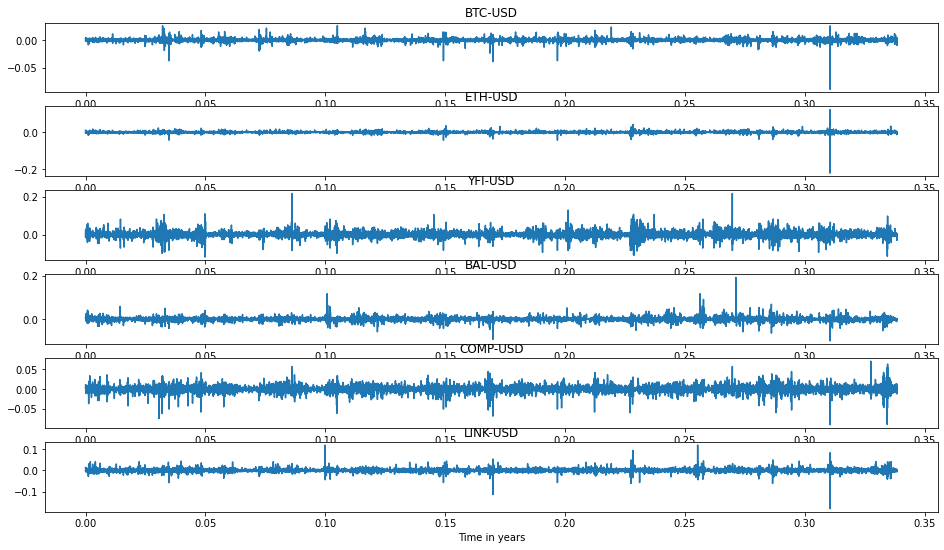

In [27]:
plot_multivariate_simulation(bootstrap_log_returns, selected_series_names, time_resolution=time_resolution)

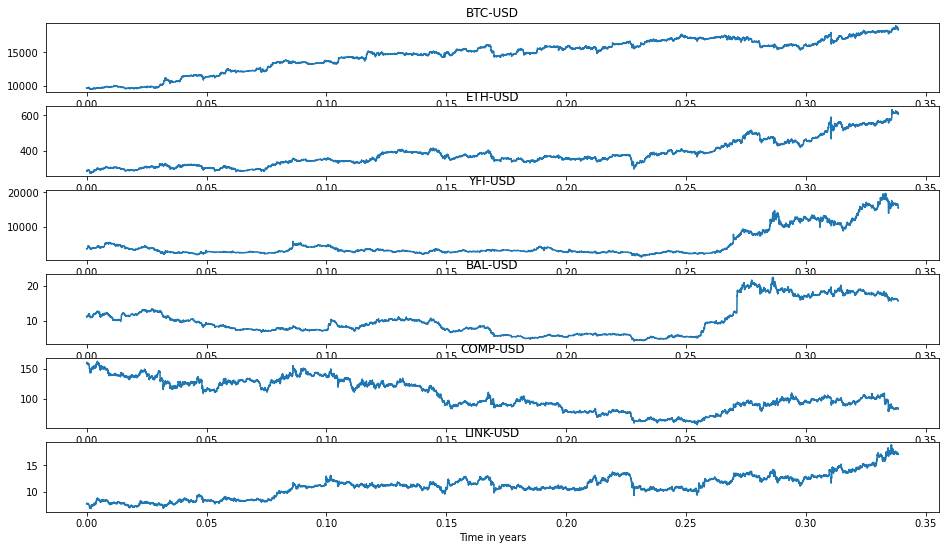

In [28]:
plot_multivariate_simulation(np.exp(bootstrap_log_prices), selected_series_names, time_resolution=time_resolution)